In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt

--2019-08-18 19:51:43--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2019-08-18 19:51:44 (90.4 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [0]:
data = open('/tmp/sonnets.txt').read()

In [0]:
corpus = data.lower().split("\n")

In [0]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [0]:
# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

In [0]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [0]:
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [9]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))


model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

W0818 19:53:03.319671 139772304598912 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0818 19:53:03.375960 139772304598912 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0818 19:53:03.383539 139772304598912 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

In [10]:
 history = model.fit(predictors, 
                     label, 
                     epochs=100, 
                     verbose=1)

W0818 19:53:29.256868 139772304598912 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
15462/15462 [==============================] - 84s 5ms/sample - loss: 6.9248 - acc: 0.0206
Epoch 2/100
15462/15462 [==============================] - 82s 5ms/sample - loss: 6.5013 - acc: 0.0230
Epoch 3/100
15462/15462 [==============================] - 82s 5ms/sample - loss: 6.3936 - acc: 0.0254
Epoch 4/100
15462/15462 [==============================] - 83s 5ms/sample - loss: 6.2732 - acc: 0.0280
Epoch 5/100
15462/15462 [==============================] - 82s 5ms/sample - loss: 6.1777 - acc: 0.0343
Epoch 6/100
15462/15462 [==============================] - 82s 5ms/sample - loss: 6.0879 - acc: 0.0383
Epoch 7/100
15462/15462 [==============================] - 82s 5ms/sample - loss: 6.0112 - acc: 0.0402
Epoch 8/100
15462/15462 [==============================] - 82s 5ms/sample - loss: 5.9316 - acc: 0.0433
Epoch 9/100
15462/15462 [==============================] - 83s 5ms/sample - loss: 5.8470 - acc: 0.0485
Epoch 10/100
15462/15462 [==============================] - 82s 5ms/sampl

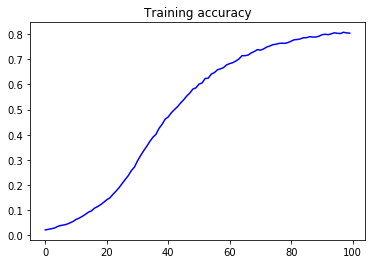

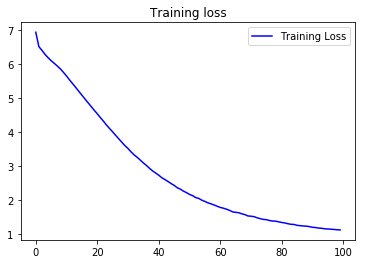

In [11]:
import matplotlib.pyplot as plt


acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [12]:
seed_text = "Life it seems to fade away, drifting further everyday"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Life it seems to fade away, drifting further everyday refusest plants increase kind alone hour seem truth on youth so ' doth despise twain dyed rare staineth new must bear pleasure you live live bright ill part men doth warm'd twain green thee how thine mine say mine eye you in you best be best to find thine gems rare near abuse me still shown made rolling rolling afloat near scorn me dyed dyed best new part ' so bright pace point an glory still out day so blot to be thee seen truly write me new bad too age another sight ' not be stay so one hour
